<a href="https://colab.research.google.com/github/swathianil/NMA_deeplearning/blob/main/Edited_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load HCP parcellated task data
## (version with Behavioural Data)

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [1]:
# @title Install dependencies
!pip install nilearn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.0 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

In [3]:
!git clone 'https://github.com/xxlya/BrainGNN_Pytorch'

Cloning into 'BrainGNN_Pytorch'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 82 (delta 7), reused 3 (delta 0), pack-reused 64
Receiving objects: 100% (82/82), 55.50 KiB | 3.70 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [4]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss_event','win_event','neut_event']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [6]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [7]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [8]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task.

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [9]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    # print(len(frames))
    # print(frames)
    # print("**************")
    frames_list.append(frames)

  return frames_list

def load_evs_dir(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/"
  stuff = os.listdir(ev_file)
  return stuff

def load_evs_beh(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/neut_event.txt"
  return ev_file

In [12]:
def load_timeserise(task, subjectID, run, remove_mean):
    right_Hemi_idx=np.arange(0,int(N_PARCELS/2),1)
    left_Hemi_idx=np.arange(int(N_PARCELS/2),N_PARCELS,1)
    data = load_single_timeseries(subject=subjectID, experiment=task, run=run, remove_mean=remove_mean)
    evs = load_evs(subject=subjectID, experiment=task, run=run)

    ## separating retions within left and right hemisphere
    timeserise_right=data[right_Hemi_idx,:]
    timeserise_left=data[left_Hemi_idx,:]
    regionNum=len(right_Hemi_idx)
    Total_Timeseries_Left=[]
    Total_Timeseries_Right=[]
    Cond_Label=[]

    for cond in range(len(EXPERIMENTS[task]['cond'])):
      trialIndex=evs[cond]
      trlLen=len(trialIndex)
      sampleNo=np.shape(trialIndex[0])[0]
      timeserise_right_trials=np.zeros((regionNum, trlLen, sampleNo))
      timeserise_left_trials=np.zeros((regionNum, trlLen, sampleNo))

      for t in range(trlLen):
        point_index=trialIndex[t]
        timeserise_right_trials[:,t,:]=timeserise_right[:,point_index]
        timeserise_left_trials[:,t,:]=timeserise_left[:,point_index]
        Cond_Label.append(EXPERIMENTS[task]['cond'][cond])

      if(cond==0):
        Total_Timeseries_Left=timeserise_left_trials
        Total_Timeseries_Right=timeserise_right_trials
      else:
        Total_Timeseries_Left=np.hstack((Total_Timeseries_Left, timeserise_left_trials))
        Total_Timeseries_Right=np.hstack((Total_Timeseries_Right, timeserise_right_trials))

    return Total_Timeseries_Left, Total_Timeseries_Right, Cond_Label

In [13]:
Total_Timeseries_Left, Total_Timeseries_Right, Cond_Label=load_timeserise(task='GAMBLING', subjectID=subjects[0] ,run=0, remove_mean=True)

print(np.shape(Total_Timeseries_Left))
print(np.shape(Total_Timeseries_Right))
print(len(Cond_Label))
print(Cond_Label)

(180, 32, 5)
(180, 32, 5)
32
['loss_event', 'loss_event', 'loss_event', 'loss_event', 'loss_event', 'loss_event', 'loss_event', 'loss_event', 'loss_event', 'loss_event', 'loss_event', 'loss_event', 'loss_event', 'loss_event', 'win_event', 'win_event', 'win_event', 'win_event', 'win_event', 'win_event', 'win_event', 'win_event', 'win_event', 'win_event', 'win_event', 'win_event', 'win_event', 'win_event', 'win_event', 'win_event', 'neut_event', 'neut_event']


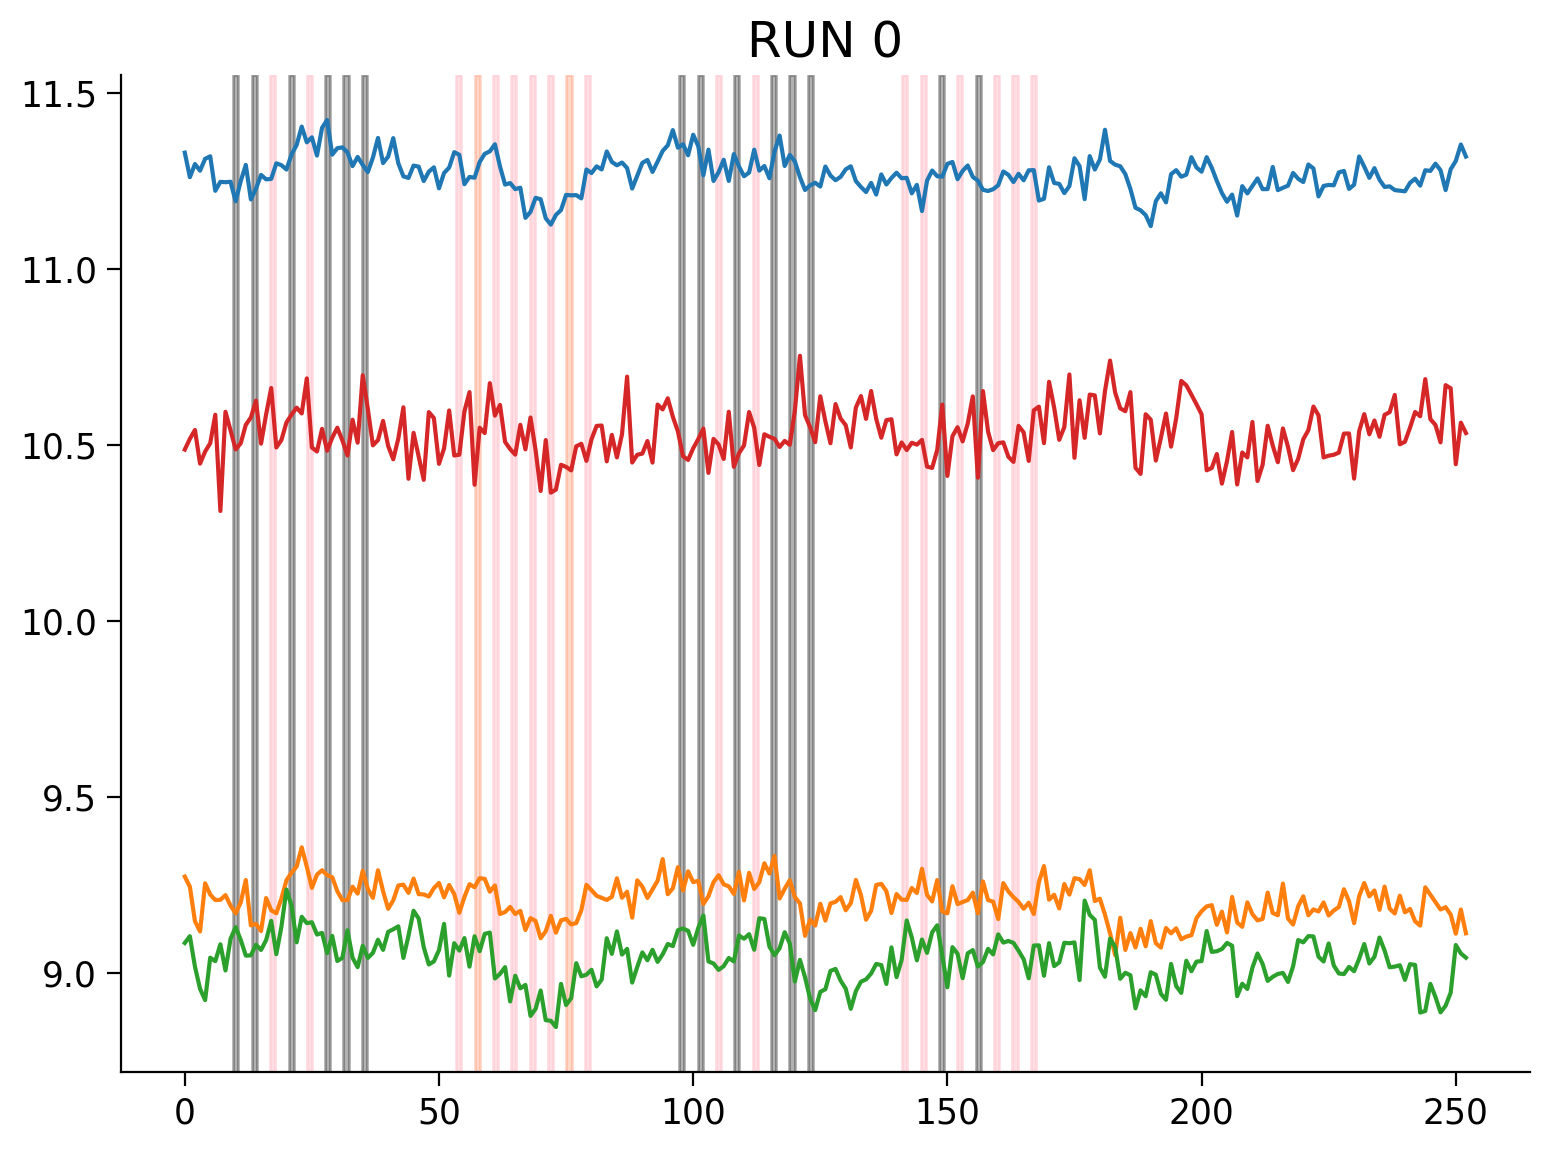

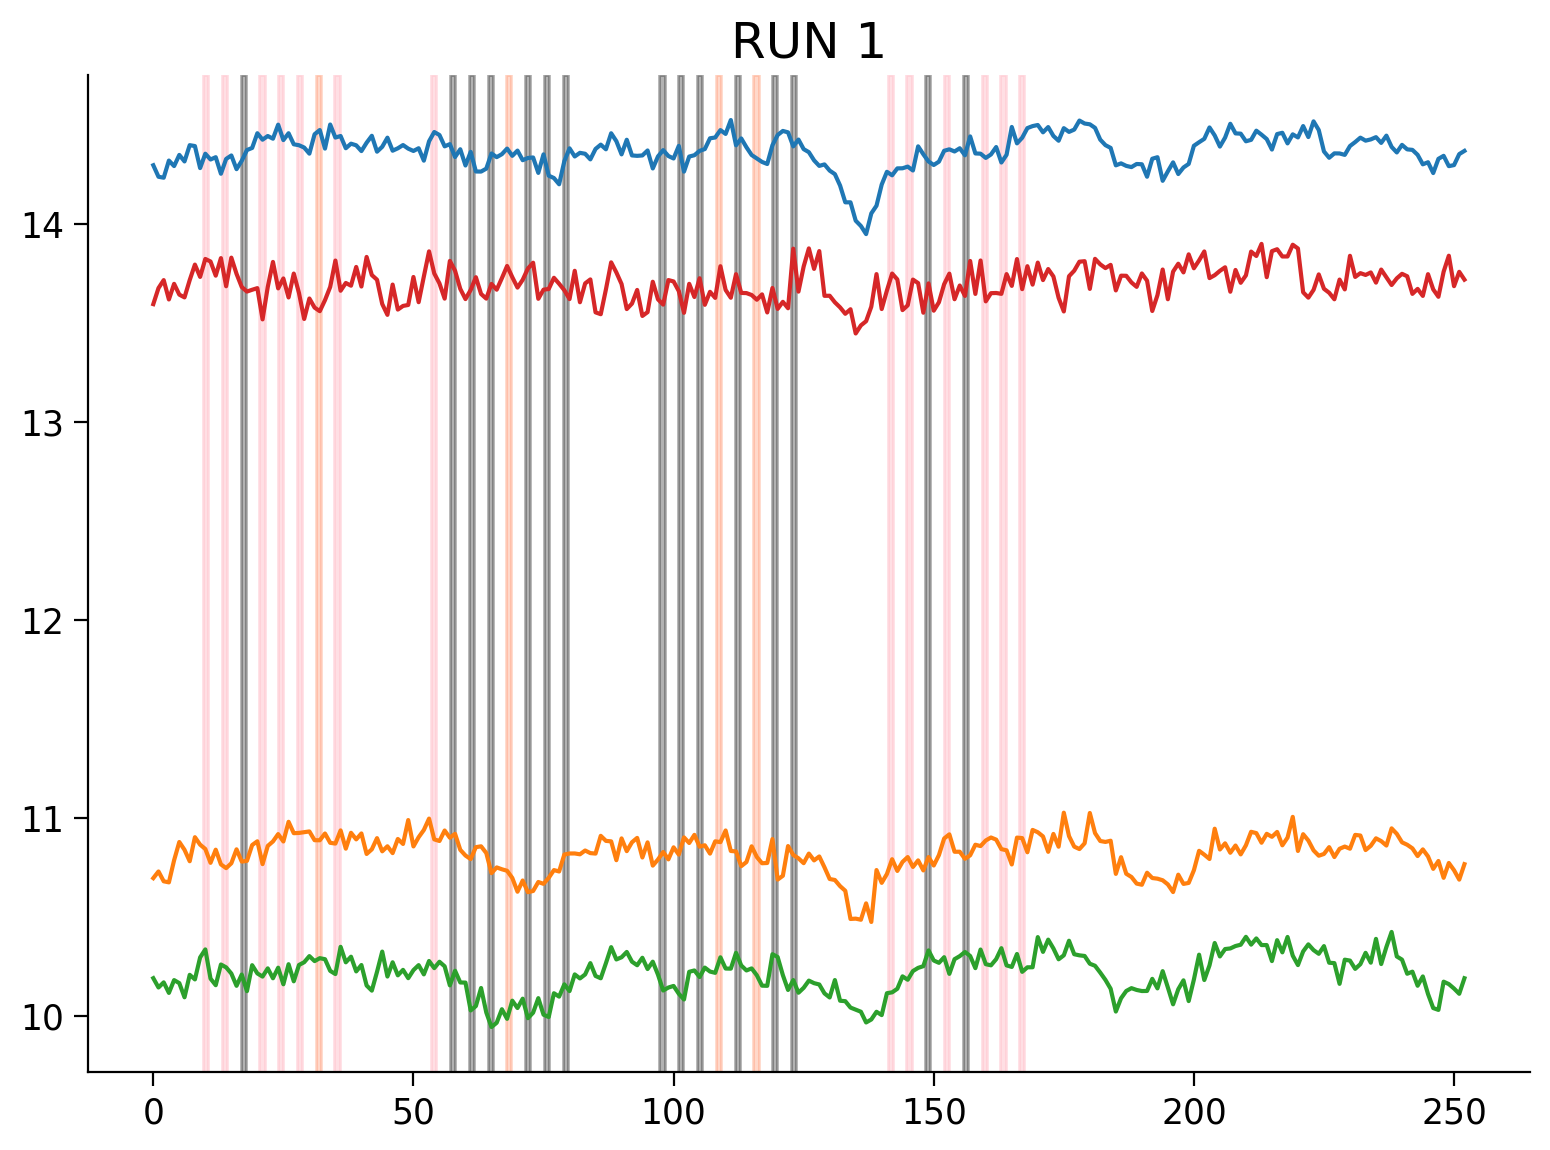

In [27]:
def plot_ts(subject,experiment, run):
  my_run = run
  #bold_path = f"{HCP_DIR}/subjects/{subject}/GAMBLING/tfMRI_GAMBLING_{RUNS[my_run]}/"
  loss_ev = np.loadtxt(f'/content/hcp_task/subjects/{my_subj}/GAMBLING/tfMRI_GAMBLING_{RUNS[my_run]}/EVs/loss_event.txt',unpack=True)[0]
  win_ev = np.loadtxt(f'/content/hcp_task/subjects/{my_subj}/GAMBLING/tfMRI_GAMBLING_{RUNS[my_run]}/EVs/win_event.txt',unpack=True)[0]
  neut_ev = np.loadtxt(f'/content/hcp_task/subjects/{my_subj}/GAMBLING/tfMRI_GAMBLING_{RUNS[my_run]}/EVs/neut_event.txt',unpack=True)[0]

  ts = load_single_timeseries(subject, experiment, run, remove_mean=False)

  plt.plot(figsize=(20,10))
  plt.title(f"RUN {my_run}")
  plt.plot(ts[0][:]/1000)
  plt.plot(ts[10][:]/1000)
  plt.plot(ts[20][:]/1000)
  plt.plot(ts[100][:]/1000)
  for xx in win_ev:
    plt.axvspan(xx+1.5, xx+2.5,color='pink',alpha=0.5, label = 'win')

  for yy in loss_ev:
    plt.axvspan(yy+1.5, yy+2.5,color='black',alpha=0.3, label = 'loss')

  for aa in neut_ev:
    plt.axvspan(aa+1.5, aa+2.5,color='coral',alpha=0.3, label = 'neut')

plot_ts(my_subj, my_exp, run=0)
#plt.legend(frameon=False, title = 'feedback')
plt.show()
plot_ts(my_subj, my_exp, run=1)

# Example run

Let's load the timeseries data for the MOTOR experiment from a single subject and a single run

In [14]:
my_exp = 'GAMBLING'
my_subj = subjects[5]
my_run = 1

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
print(data.shape)

(360, 253)


As you can see the time series data contains 284 time points in 360 regions of interest (ROIs).



Now in order to understand how to model these data, we need to relate the time series to the experimental manipulation. This is described by the EV files. Let us load the EVs for this experiment.

In [15]:
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)
# see whats in the envs for an experiment
options = load_evs_dir(subject=my_subj, experiment=my_exp, run=my_run)
print(options)

['win_event.txt', 'Sync.txt', 'Stats.txt', 'loss.txt', 'neut_event.txt', 'loss_event.txt', 'win.txt']


In [16]:
# download a txt file if you want
beh = load_evs_beh(subject=my_subj, experiment=my_exp, run=my_run)
files.download(beh)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
print(beh)
EXPERIMENTS['GAMBLING']['cond']

./hcp_task/subjects/103515/GAMBLING/tfMRI_GAMBLING_RL/EVs/neut_event.txt


['loss_event', 'win_event', 'neut_event']

Mean RT: 500.625
Percent NLR: 0.0
NLR as ACC: 1.0

For the motor task, this evs variable contains a list of 5 arrays corresponding to the 5 conditions.

Now let's use these evs to compare the average activity during the left foot ('lf') and right foot ('rf') conditions:

In [22]:
# we need a little function that averages all frames from any given condition
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]+2], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)

def idx_check(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return idx

test = idx_check(data, evs, my_exp, 'loss')
loss = average_frames(data, evs, my_exp, 'loss')
win = average_frames(data, evs, my_exp, 'win')
loss_event = average_frames(data, evs, my_exp, 'loss_event')
win_event = average_frames(data, evs, my_exp, 'win_event')

contrast = win_event - loss_event  # difference between win/loss condition

ValueError: ignored

In [ ]:
# Plot activity level in each ROI for both conditions
#plt.plot(loss,label='loss')
#plt.plot(win,label='win')
plt.plot(loss_event,label='loss_event')
plt.plot(win_event,label='win_event')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

Now let's plot these activity vectors. We will also make use of the ROI names to find out which brain areas show highest activity in these conditions. But since there are so many areas, we will group them by network.

A powerful tool for organising and plotting this data is the combination of pandas and seaborn. Below is an example where we use pandas to create a table for the activity data and we use seaborn oto visualise it.





In [ ]:
df = pd.DataFrame({'loss_event' : loss_event,
                   'win_event' : win_event,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(y='network', x='loss_event', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='win_event', data=df, hue='hemi',ax=ax2)
plt.show()

In [ ]:
df = pd.DataFrame({'win_event' : win_event,
                   'loss_event' : loss_event,
                   'network' : region_info['network']})

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(y='network', x='loss_event', data=df,ax=ax1)
sns.barplot(y='network', x='win_event', data=df,ax=ax2)
plt.show()

You should be able to notice that for the somatosensory network, brain activity in the right hemi is higher for the left foot movement and vice versa for the left hemi and right foot. But this may be subtle at the single subject/session level (these are quick 3-4min scans).


Let us boost thee stats by averaging across all subjects and runs.

In [ ]:
group_contrast = 0
for s in subjects:
  for r in [0, 1]:
    data = load_single_timeseries(subject=s, experiment=my_exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    win_event_act = average_frames(data, evs, my_exp, 'win_event')
    loss_event_act = average_frames(data, evs, my_exp, 'loss_event')

    contrast = win_event_act - loss_event_act
    group_contrast += contrast

group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject

In [ ]:
df = pd.DataFrame({'contrast' : group_contrast,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']
                   })
# we will plot the left foot minus right foot contrast so we only need one plot
plt.figure()
sns.barplot(y='network', x='contrast', data=df, hue='hemi')
plt.show()

In [ ]:
df = pd.DataFrame({'contrast' : group_contrast,
                   'network' : region_info['network']})
# we will plot the left foot minus right foot contrast so we only need one plot
plt.figure()
sns.barplot(y='network', x='contrast', data=df)
plt.show()

# Visualising the results on a brain

Finally, we will visualise these resuts on the cortical surface of an average brain.

In [ ]:
# @title NMA provides an atlas. Run this cell to download it
import os, requests

# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

with np.load(fname) as dobj:
  atlas = dict(**dobj)

In [ ]:
print(atlas)

In [ ]:
# This uses the nilearn package
from nilearn import plotting, datasets

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=20)

In [ ]:
from scipy import stats
def normalize (subjects, experiment, run):

    dataMat = []
    for i in range (len(subjects)):
        ds = load_single_timeseries(subjects[i], experiment, run, remove_mean=True)
        dataMat.append (ds)
    dataMat = np.array(dataMat)
    # print (dataMat.shape)
    zscore = stats.zscore(dataMat, axis=1)
    # print (zscore.shape)

    return zscore
